In [1]:
import os
import sys
import itertools

import numpy as np 
import pandas as pd
import nibabel as nib

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

import pipelineloader as pl

%matplotlib inline

In [2]:
ATLAS = "dk"
REG_TO_LOBE = list(np.genfromtxt("../util/dk-lobes.txt", usecols=(1,), dtype=str))

class LabelVol():
    """Wrapper around nifti label volume"""

    def __init__(self, filename, dist_lim):
        label_vol = nib.load(filename)

        self.data = label_vol.get_data().astype(int) - 1
        self.affine = label_vol.affine
        self.set_coord_sequence(dist_lim)
        self.outside_index = -1
        self.dist_lim = dist_lim


    def set_coord_sequence(self, lim):
        ncellsx = int(lim/np.linalg.norm(self.affine[0:3, 0:3] @ np.array([1, 0, 0]))) + 1
        ncellsy = int(lim/np.linalg.norm(self.affine[0:3, 0:3] @ np.array([0, 1, 0]))) + 1
        ncellsz = int(lim/np.linalg.norm(self.affine[0:3, 0:3] @ np.array([0, 0, 1]))) + 1

        indx = np.arange(-ncellsx, ncellsx + 1, 1)
        indy = np.arange(-ncellsy, ncellsy + 1, 1)
        indz = np.arange(-ncellsz, ncellsz + 1, 1)

        coords = np.array(list(itertools.product(indx, indy, indz)), dtype=int)
        dists = np.array([np.linalg.norm(self.affine[0:3, 0:3] @ np.array(c)) for c in coords])
        mask = dists <= lim

        sdists, scoords = zip(*sorted(zip(dists[mask].tolist(), coords[mask, :].tolist())))
        self.dists = np.array(sdists)
        self.coords = np.array(scoords)


    def get_close_regions(self, point, n=None, only=None):
        regs = []
        dists = []

        pcoords = np.linalg.solve(self.affine, np.append(point, 1.0))[0:3].astype(int)
        for dist, coords_delta in zip(self.dists, self.coords):
            if len(regs) == n:
                break

            vcoords = pcoords + coords_delta
            if np.any([vcoords[i] < 0 or vcoords[i] >= self.data.shape[i] for i in range(3)]):
                continue

            reg = self.data[tuple(vcoords)]
            if (reg == self.outside_index) or (reg in regs):
                continue
            else:
                if (only is not None) and (reg not in only):
                    continue

                regs.append(reg)
                dists.append(dist)

        return regs, dists

In [3]:
dfr = pd.read_pickle("../run/Taa/df-results-rec.pkl")
dfm = pd.read_pickle("../run/Taa/df-results-sim.pkl")
dfm = dfm[(dfm.model == 'propwaves') & (dfm.noise == 1)]

## Spatial location: Which lobe?

In [4]:
for df in [dfm, dfr]:
    s = pd.Series(data=np.zeros(len(df), dtype=int), dtype='category')
    s.cat.categories = ['Unknown']
    s = s.cat.set_categories(['Unknown'] + list(np.unique(REG_TO_LOBE))) 

    df.lobe = s

/home/viktorsip/soft/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [ ]:
for sid in range(1, 51):    
    
    subject_name = f"id{sid:03d}"
    print(subject_name, end=' ', flush=True)
    
    dffm = dfm[dfm.subject == subject_name]
    dffr = dfr[dfr.subject == subject_name]    
        
    subj = pl.Subject(sid, 'dk')
    labelvol = LabelVol(os.path.join(subj.direc, "dwi", "label_in_T1.dk.nii.gz"), 30.0)
    contacts = np.unique(np.concatenate([dffm.contact.unique(), dffr.contact.unique()]))
    
    for contact in contacts:
        pos = subj.contacts.name_to_xyz[contact]
        reg = labelvol.get_close_regions(pos, n=1)[0][0]
                
        dfffm = dffm[dffm.contact == contact]
        dfffr = dffr[dffr.contact == contact]
        
        dfm.loc[dfffm.index, 'lobe'] = REG_TO_LOBE[reg]
        dfr.loc[dfffr.index, 'lobe'] = REG_TO_LOBE[reg]

id001 

/home/viktorsip/projects/pipelineloader/pipelineloader/contacts.py:10: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  data = np.genfromtxt(fl, dtype=None)


id002 id003 id004 id005 

In [ ]:
dfm['lobe'].value_counts()

In [8]:
dfm['t_onset'] = 10.0

dfr['onset'] = 0.
for subject, rec in dfr[['subject', 'rec']].drop_duplicates().values:
    t_onset = np.load(f"../data/Recordings/{subject}/rec_{rec:04d}.npz")['onset']
    dfr.loc[(dfr.subject == subject) & (dfr.rec == rec), 't_onset'] = t_onset

In [9]:
import itertools

def add_panel_letters(fig, axes=None, fontsize=30, xpos=-0.04, ypos=1.05):
    labels = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    
    if axes is None:
        axes = fig.get_axes()

    if type(xpos) == float:
        xpos = itertools.repeat(xpos)
    if type(ypos) == float:
        ypos = itertools.repeat(ypos)

    for i, (ax, x, y) in enumerate(zip(axes, xpos, ypos)):
        ax.text(x, y, labels[i],
                transform=ax.transAxes, size=fontsize, weight='bold')

In [10]:
n = np.zeros(7, dtype=int)
nszg = np.zeros(7, dtype=int)
ntaa = np.zeros(7, dtype=int)
ngrp = np.zeros(7, dtype=int)
labels = ["" for _ in range(7)]

n[0] = len(dfr)
nszg[0] = dfr.is_seizing.sum()
ntaa[0] = dfr.is_taa.sum()
ngrp[0] = dfr.is_ingroup.sum()

for i, model in enumerate(['onestat', 'twostat', 'propwaves']):
    for j, noise in enumerate([0, 1]):
        dff = dfm[(dfm.model == model) & (dfm.noise == noise)]

        ind = 2*i + j + 1
        n[ind] = len(dff)
        nszg[ind] = dff.is_seizing.sum()
        ntaa[ind] = dff.is_taa.sum()
        ngrp[ind] = dff.is_ingroup.sum()

/home/viktorsip/soft/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


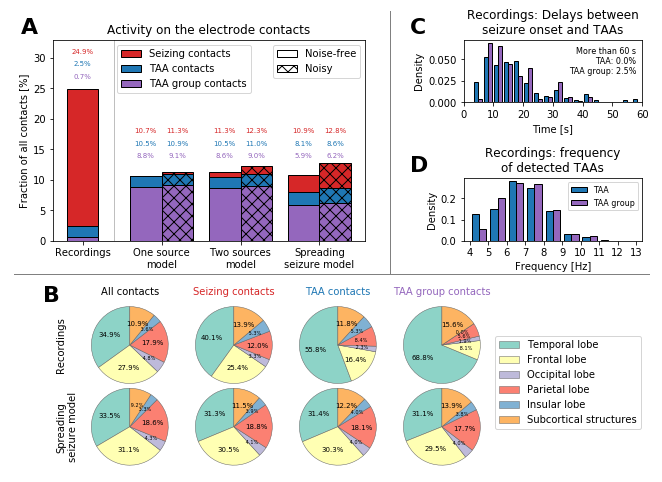

In [22]:
dfs = [dfr, dfm[(dfm.model == 'propwaves') & (dfm.noise == 1)]]

colors = ['k', 'tab:red', 'tab:blue', 'tab:purple']
xlabels = ["All contacts", "Seizing contacts", "TAA contacts", "TAA group contacts"]
ylabels = ["Recordings\n", "Spreading\nseizure model"]
lobes = ["Temporal", "Frontal", "Occipital", "Parietal", "Insular", "Subcortical"]
lobe_labels = ["Temporal lobe", "Frontal lobe", "Occipital lobe", "Parietal lobe", "Insular lobe",
              "Subcortical structures"]


fig = plt.figure(figsize=(9, 6.5))


gs1 = fig.add_gridspec(nrows=2, ncols=2, left=0.07, right=0.98, bottom=0.5, top=0.93,
                       wspace=0.4, hspace=1.2, width_ratios=[3.5, 2])
gs2 = fig.add_gridspec(nrows=2, ncols=4, left=0.1, right=0.76, bottom=0.00, top=0.38,
                       wspace=-0.1, hspace=-0.15)

# Number of detected TAAs --------------------------------------------------------
ax0 = fig.add_subplot(gs1[0:2, 0])
plt.title("Activity on the electrode contacts")

# Bars
inds = np.array([0, 1, 3, 5])
plt.bar([0, 0.8, 1.8, 2.8], 100*(nszg/n)[inds], width=0.4, color=colors[1], ec='k', label='Seizing contacts')
plt.bar([0, 0.8, 1.8, 2.8], 100*(ntaa/n)[inds], width=0.4, color=colors[2], ec='k', label='TAA contacts')
plt.bar([0, 0.8, 1.8, 2.8], 100*(ngrp/n)[inds], width=0.4, color=colors[3], ec='k', label='TAA group contacts')

inds = np.array([2, 4, 6])
plt.bar([1.2, 2.2, 3.2], 100*(nszg/n)[inds], width=0.4, color=colors[1], ec='k', hatch='xx')
plt.bar([1.2, 2.2, 3.2], 100*(ntaa/n)[inds], width=0.4, color=colors[2], ec='k', hatch='xx')
plt.bar([1.2, 2.2, 3.2], 100*(ngrp/n)[inds], width=0.4, color=colors[3], ec='k', hatch='xx')

# Text
args = dict(ha='center', va='center', fontsize=7)
for i, xpos in enumerate([0, 0.8, 1.2, 1.8, 2.2, 2.8, 3.2]):
    ypos = 25 if i == 0 else 12    
    plt.text(xpos, ypos + 6., f"{100*nszg[i]/n[i]:.1f}%",  color=colors[1], **args)
    plt.text(xpos, ypos + 4., f"{100*ntaa[i]/n[i]:.1f}%",  color=colors[2], **args)
    plt.text(xpos, ypos + 2., f"{100*ngrp[i]/n[i]:.1f}%",  color=colors[3], **args)
    
# Legends
leg1 = plt.legend(loc='upper left', bbox_to_anchor=(0.19, 1.00))
handles = [mpatches.Patch(fc='w', ec='k', hatch=h) for h in [None, 'xx']]
leg2 = plt.legend(handles, ["Noise-free", "Noisy"], loc='upper right')
plt.gca().add_artist(leg1)
    
plt.axvline(0.4, color='0.5', lw=0.5)    
plt.ylim(0., 33.)
plt.ylabel("Fraction of all contacts [%]")

plt.xticks([0, 1, 2, 3], ["Recordings", "One source\nmodel", "Two sources\nmodel", "Spreading\nseizure model"]);


# Spatial location -------------------------------------------------------------- # 
axes = []
for i, df in enumerate(dfs):
    for j, mask in enumerate([np.ones(len(df), dtype=bool), df.is_seizing, df.is_taa, df.is_ingroup]):
        ax = fig.add_subplot(gs2[i, j])
        ax.set_prop_cycle(color=get_cmap('Set3').colors)
        axes.append(ax)
        
        counts = [df[mask].lobe.value_counts().get(lobe, 0) for lobe in lobes]
        # labels = [f"{100 * c / np.sum(counts):.2f}%" for c in counts]
        wedges, text, autotexts = plt.pie(counts,
                                          # labels=labels,
                                          autopct=lambda pct: f"{pct:4.1f}%", # if pct > 10 else "",
                                          wedgeprops={'linewidth': 0.5, 'ls': '-', 'edgecolor': '0.4'},
                                          pctdistance=0.6, 
                                          startangle=90)
        for k, text in enumerate(autotexts):
             text.set_fontsize(7 if counts[k] / np.sum(counts) > 0.1 else 5)
            
    
        if i == 0 and j == 3:
            # legend = plt.legend(wedges, labels=lobes, loc='lower left', 
            #                     bbox_to_anchor=(0.25, -0.4, 3., 0.4), ncol=3)
            legend = plt.legend(wedges, labels=lobe_labels, loc='upper left', 
                                bbox_to_anchor=(1.0, -0.35, 1., 1.), ncol=1)
            
        if i == 0:
            plt.title(xlabels[j], fontsize=10, color=colors[j], va='top')
            
        if j == 0:
            plt.ylabel(ylabels[i], fontsize=10)
            
# Temporal location --------------------------------------------------------------- #             
dff1 = dfr[dfr.is_taa]
dff2 = dfr[dfr.is_ingroup]

ax1 = fig.add_subplot(gs1[0, 1])
plt.title("Recordings: Delays between\nseizure onset and TAAs")
plt.hist([dff1.tfr - dff1.t_onset, dff2.tfr - dff2.t_onset], bins=np.linspace(0, 60, 19),
         color=[colors[2], colors[3]], ec='k', density=True)
plt.text(58, 0.065, "More than 60 s\n"
                    f"TAA: {100 * np.mean(dff.tfr - dff.t_onset > 60.):.1f}%\n"
                    f"TAA group: {100 * np.mean(dff2.tfr - dff2.t_onset > 60):.1f}%",
         ha='right', va='top', fontsize=8)
plt.xlabel("Time [s]")
# plt.yticks([])
plt.xlim(0, 60)
plt.xticks([0, 10, 20, 30, 40, 50, 60])
plt.ylabel("Density")

ax2 = fig.add_subplot(gs1[1, 1])
plt.title("Recordings: frequency\nof detected TAAs")
plt.hist([dff1.freq, dff2.freq], bins=np.linspace(4, 13, 10), 
         color=[colors[2], colors[3]], label=["TAA", "TAA group"],
         ec='k', density=True)
plt.xticks(np.linspace(4, 13, 10))
plt.xlabel("Frequency [Hz]")
# plt.yticks([])
plt.ylabel("Density")
plt.legend(loc='upper right', fontsize=8)


axbg = plt.axes([0,0,1,1], facecolor='none')
axbg.add_line(Line2D([0.01, 0.99], [0.43, 0.43], lw=1., color='0.5'))
axbg.add_line(Line2D([0.59, 0.59], [0.43, 0.99], lw=1., color='0.5'))
plt.axis('off')
     
add_panel_letters(fig, [ax0, axes[0], ax1, ax2], fontsize=22,
                  xpos=[-0.1, -0.4, -0.3, -0.3], ypos=[1.03, 0.95, 1.1, 1.1])

plt.savefig("figs/taa-location.pdf")

## ------------------------------------------------------------------------------------